# Лабораторная работа 3. Цифровая обработка изображений.

В этой работе рассматриваются различные виды цифровой обработки изображений.

Цель лабораторной работы:
1. Метрики качества.
2. Фильтрация изображений
3. Линейная фильтрация изображений в пространственной области.
4. Линейная фильтрация изображений в частотной области

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
import sys
#sys.path.append('../')
%matplotlib inline
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
#from utility import util

Matplotlib is building the font cache; this may take a moment.


In [3]:
# Изменим стандартный размер графиков matplotlib
plt.rcParams["figure.figsize"] = [9, 6]

## Метрики качества. Среднеквадратическая ошибка (MSE). Пиковое отношение сигнал/шум (PSNR). SSIM.

In [4]:
def getPSNR(I1, I2):
    s1 = cv.absdiff(I1, I2)  #|I1 - I2| - модуль разницы двух изображений
    s1 = np.float32(s1)
    s1 = s1 * s1  # |I1 - I2|^2
    sse = s1.sum()  # сумма элементов в каждом канале
    if sse <= 1e-10:  # сумма каналов
        return 0
    else:
        shape = I1.shape
        p=1
        for i in shape:
          p *= i
        mse = 1.0 * sse /p
        psnr = 10.0 * np.log10((255 * 255) / mse)
        return psnr

In [5]:
def getSSIM(i1, i2):
    C1 = 6.5025  # для 8-битного изоражения
    C2 = 58.5225  # для 8-битного изоражения
    # INITS
    I1 = np.float32(i1)
    I2 = np.float32(i2)
    I2_2 = I2 * I2  # I2^2
    I1_2 = I1 * I1  # I1^2
    I1_I2 = I1 * I2  # I1 * I2

    mu1 = cv.GaussianBlur(I1, (11, 11), 1.5)
    mu2 = cv.GaussianBlur(I2, (11, 11), 1.5)
    mu1_2 = mu1 * mu1
    mu2_2 = mu2 * mu2
    mu1_mu2 = mu1 * mu2
    sigma1_2 = cv.GaussianBlur(I1_2, (11, 11), 1.5)
    sigma1_2 -= mu1_2
    sigma2_2 = cv.GaussianBlur(I2_2, (11, 11), 1.5)
    sigma2_2 -= mu2_2
    sigma12 = cv.GaussianBlur(I1_I2, (11, 11), 1.5)
    sigma12 -= mu1_mu2
    t1 = 2 * mu1_mu2 + C1
    t2 = 2 * sigma12 + C2
    t3 = t1 * t2  # t3 = ((2*mu1_mu2 + C1).*(2*sigma12 + C2))
    t1 = mu1_2 + mu2_2 + C1
    t2 = sigma1_2 + sigma2_2 + C2
    t1 = t1 * t2  # t1 =((mu1_2 + mu2_2 + C1).*(sigma1_2 + sigma2_2 + C2))
    ssim_map = cv.divide(t3, t1)  # ssim_map =  t3./t1;
    ssim = cv.mean(ssim_map)  # mssim = average of ssim map
    ssim = ssim[:3]
    return ssim

## Загрузим изображение, подберем обратную матрицу для сдвига

In [6]:
drunk_image = cv.imread('./test_image.jpg')
height, width = drunk_image.shape[:2]  # 256 x 470

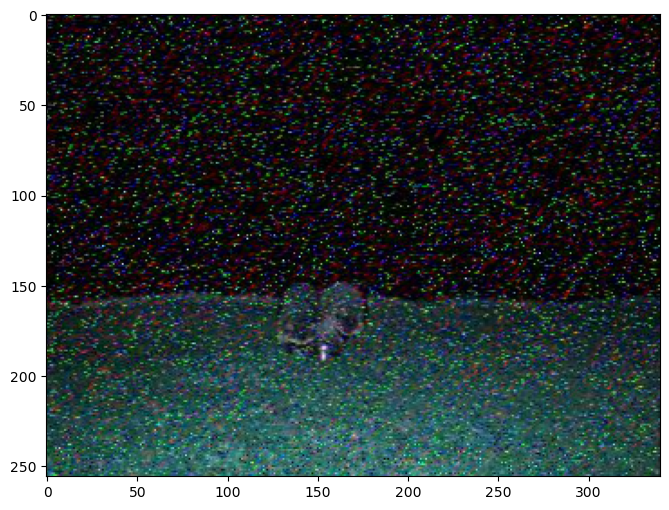

In [7]:
# Вычисляем коэффициент
original_width = 340
original_height = 256
k = (width - original_width) / original_height

M_inv = np.float32([[1, -k, 0],
                    [0,  1, 0]])
straight = cv.warpAffine(drunk_image, M_inv, (original_width, original_height))

plt.imshow(straight)

## Медианная фильтрация


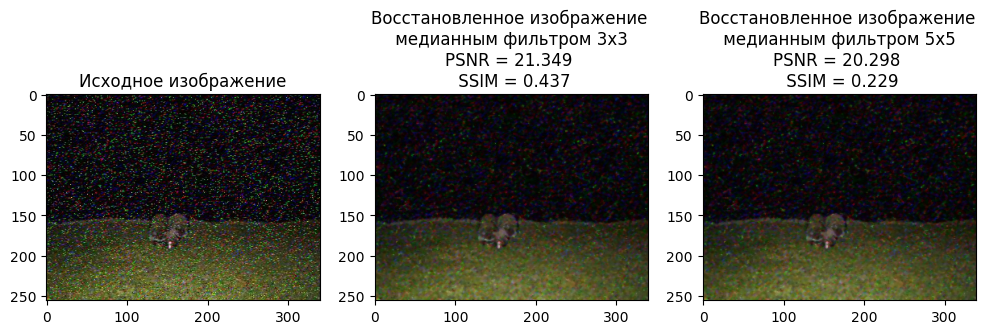

In [8]:
image1 = cv.cvtColor(straight, cv.COLOR_BGR2RGB)

median_image1 = cv.medianBlur(image1, 3)
median_image2 = cv.medianBlur(image1, 5)

gs = plt.GridSpec(1, 3)
plt.figure(figsize=(12, 14))
plt.subplot(gs[0])
plt.imshow(image1, cmap='viridis')
plt.title('Исходное изображение')

plt.subplot(gs[1])
plt.imshow(median_image1, cmap='viridis')
psnr = getPSNR(image1, median_image1)
ssim = getSSIM(image1, median_image1)
plt.title(f'Восстановленное изображение \n '
          f'медианным фильтром 3х3 \n'
          f'PSNR = {psnr:.3f} \n SSIM = {ssim[0]:.3f}')

plt.subplot(gs[2])
plt.imshow(median_image1, cmap='viridis')
psnr = getPSNR(image1, median_image2)
ssim = getSSIM(image1, median_image2)
plt.title(f'Восстановленное изображение \n '
          f'медианным фильтром 5х5 \n'
          f'PSNR = {psnr:.3f} \n SSIM = {ssim[0]:.3f}')

plt.show()

## Линейная фильтрация изображений в пространственной области. Гауссиан

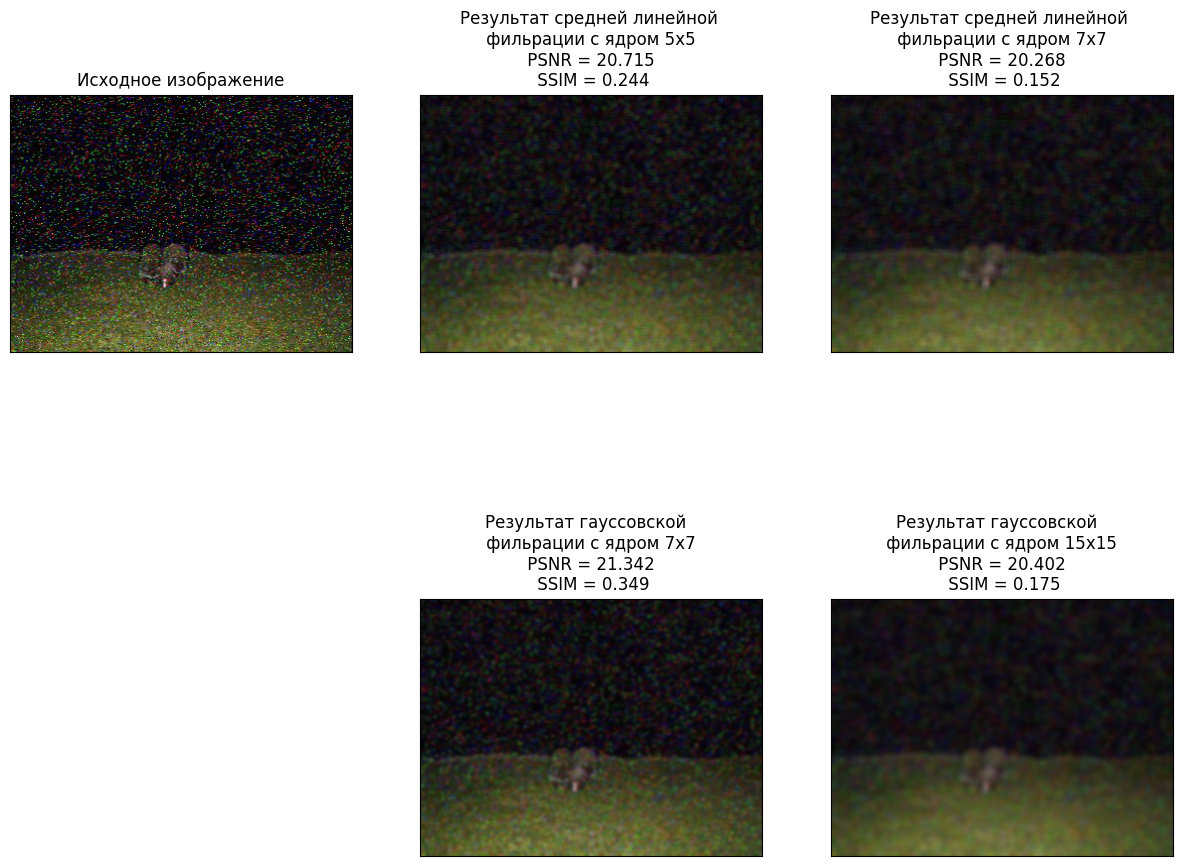

In [9]:
kernel55 = np.ones((5, 5), np.float32) / 25
kernel77 = np.ones((7, 7), np.float32) / 49

filtered_image1 = cv.filter2D(image1, -1, kernel55)
filtered_image2 = cv.filter2D(image1, -1, kernel77)
gaussian_image1 = cv.GaussianBlur(image1, (7, 7), 0)
gaussian_image2 = cv.GaussianBlur(image1, (15, 15), 0)

# вывод
gs = plt.GridSpec(2, 3)
plt.figure(figsize=(15, 12))

plt.subplot(gs[0, 0])
plt.xticks([]), plt.yticks([])
plt.title('Исходное изображение')
plt.imshow(image1, cmap='gray')

plt.subplot(gs[0, 1])
plt.xticks([]), plt.yticks([])
plt.title(f'Результат средней линейной \n фильрации с ядром 5х5 \n '
          f'PSNR = {getPSNR(image1, filtered_image1):.3f} \n '
          f'SSIM = {getSSIM(image1, filtered_image1)[0]:.3f}')
plt.imshow(filtered_image1, 'gray')

plt.subplot(gs[0, 2])
plt.xticks([]), plt.yticks([])
plt.title(f'Результат средней линейной \n фильрации с ядром 7х7 \n '
          f'PSNR = {getPSNR(image1, filtered_image2):.3f} \n '
          f'SSIM = {getSSIM(image1, filtered_image2)[0]:.3f}')
plt.imshow(filtered_image2, 'gray')

plt.subplot(gs[1, 1])
plt.xticks([]), plt.yticks([])
plt.title(f'Результат гауссовской  \n фильрации с ядром 7х7 \n '
          f'PSNR = {getPSNR(image1, gaussian_image1):.3f} \n '
          f'SSIM = {getSSIM(image1, gaussian_image1)[0]:.3f}')
plt.imshow(gaussian_image1, 'gray')

plt.subplot(gs[1, 2])
plt.xticks([]), plt.yticks([])
plt.title(f'Результат гауссовской  \n фильрации с ядром 15х15 \n '
          f'PSNR = {getPSNR(image1, gaussian_image2):.3f} \n '
          f'SSIM = {getSSIM(image1, gaussian_image2)[0]:.3f}')
plt.imshow(gaussian_image2, 'gray')

plt.show()

~~Всё ещё ноль догадок, что на изображении~~

Результат гауссовской фильрации с ядром 7х7 незначительно лучше медианного фильтра 3х3 по параметру PSNR, но медианный лучше сохранил границы изображения, если верить SSIM.


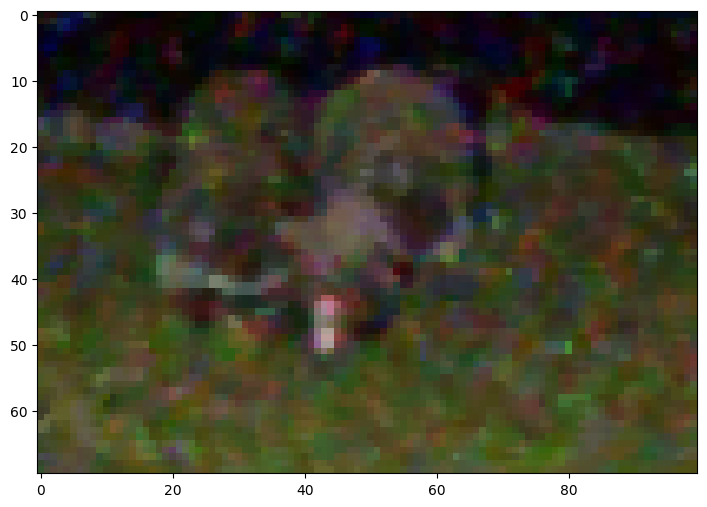

In [10]:
ROI = (110, 140, 100, 70)  #(x0, y0, width, height)
cropped_image = median_image1[ROI[1]:ROI[1] + ROI[3], ROI[0]:ROI[0] + ROI[2]]
plt.imshow(cropped_image)

## Повышение резкости изображения

Попробудемп повысить резкость изображения, отфильрованное мадианным фильтром и гауссианом. Для этого вернем их со следующими ядрами (у них нет специальных названий, поэтому просто пронумеруем их):


Ядро 1:
$
 \begin{pmatrix}
  -1 & -1 & -1 \\
  -1 & 9 & -1 \\
  -1 & -1 & -1
 \end{pmatrix}
$

Ядро 2:
$
 \begin{pmatrix}
  -0.25 & -0.25 & -0.25 \\
  -0.25 & 3 & -0.25 \\
  -0.25 & -0.25 & -0.25
 \end{pmatrix}
$

Ядро 3:
$
 \begin{pmatrix}
  0 & -0.25 & 0 \\
  -0.25 & 2 & -0.25 \\
  0 & -0.25 & 0
 \end{pmatrix}
$


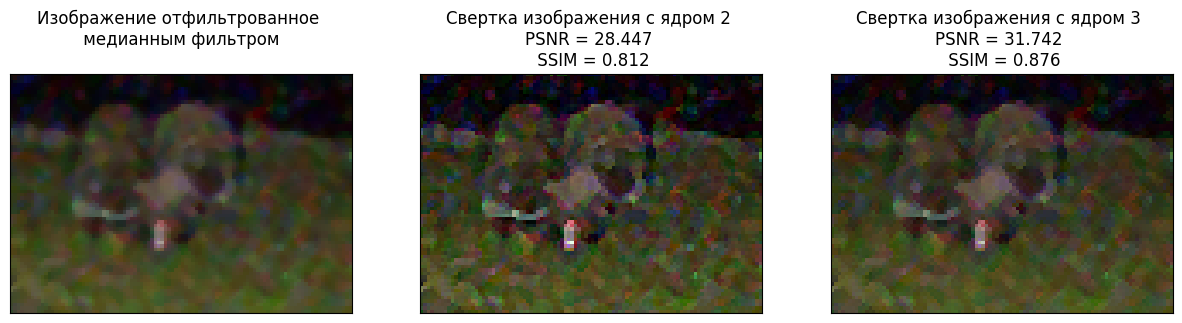

In [11]:
kernel1 = np.asarray([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
kernel2 = np.asarray([[-0.25, -0.25, -0.25], [-0.25, 3, -0.25], [-0.25, -0.25, -0.25]])
kernel3 = np.asarray([[0, -0.25, 0], [-0.25, 2, -0.25], [0, -0.25, 0]])

image1_median = cv.medianBlur(cropped_image, 3)

filtered_image1 = cv.filter2D(image1_median, -1, kernel1)
filtered_image2 = cv.filter2D(image1_median, -1, kernel2)
filtered_image3 = cv.filter2D(image1_median, -1, kernel3)

# вывод
plt.figure(figsize=(15, 17))
plt.subplot(331)
plt.xticks([]), plt.yticks([])
plt.title('Изображение отфильтрованное \n медианным фильтром \n')
plt.imshow(image1_median, cmap='gray')

plt.subplot(332)
plt.xticks([]), plt.yticks([])
plt.title(f'Свертка изображения с ядром 2 \n'
          f'PSNR = {getPSNR(cropped_image, filtered_image2):.3f} \n '
          f'SSIM = {getSSIM(cropped_image, filtered_image2)[0]:.3f}')
plt.imshow(filtered_image2, 'gray')

plt.subplot(333)
plt.xticks([]), plt.yticks([])
plt.title(f'Свертка изображения с ядром 3 \n'
          f'PSNR = {getPSNR(cropped_image, filtered_image3):.3f} \n '
          f'SSIM = {getSSIM(cropped_image, filtered_image3)[0]:.3f}')
plt.imshow(filtered_image3, 'gray')

plt.show()

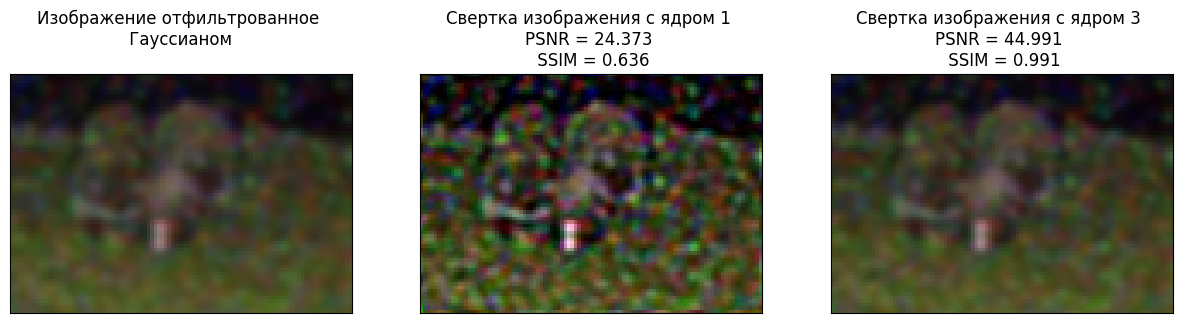

In [12]:
ROI = (110, 140, 100, 70)  #(x0, y0, width, height)
cropped_image2 = gaussian_image1[ROI[1]:ROI[1] + ROI[3], ROI[0]:ROI[0] + ROI[2]]

filtered_image1 = cv.filter2D(cropped_image2, -1, kernel1)
filtered_image2 = cv.filter2D(cropped_image2, -1, kernel2)
filtered_image3 = cv.filter2D(cropped_image2, -1, kernel3)

# вывод
plt.figure(figsize=(15, 17))
plt.subplot(331)
plt.xticks([]), plt.yticks([])
plt.title('Изображение отфильтрованное \n Гауссианом \n')
plt.imshow(cropped_image2, cmap='gray')

plt.subplot(332)
plt.xticks([]), plt.yticks([])
plt.title(f'Свертка изображения с ядром 1 \n'
          f'PSNR = {getPSNR(cropped_image2, filtered_image1):.3f} \n '
          f'SSIM = {getSSIM(cropped_image2, filtered_image1)[0]:.3f}')
plt.imshow(filtered_image1, 'gray')

plt.subplot(333)
plt.xticks([]), plt.yticks([])
plt.title(f'Свертка изображения с ядром 3 \n'
          f'PSNR = {getPSNR(cropped_image2, filtered_image3):.3f} \n '
          f'SSIM = {getSSIM(cropped_image2, filtered_image3)[0]:.3f}')
plt.imshow(filtered_image3, 'gray')

plt.show()

PSNR почти 45 и SSIM близко к 1. Делаем вывод, что картинка практически не изменилась, несмотря на все старания.

## Линейная фильтрация изображений в частотной области.
Лучше не стало, но все равно интересно.

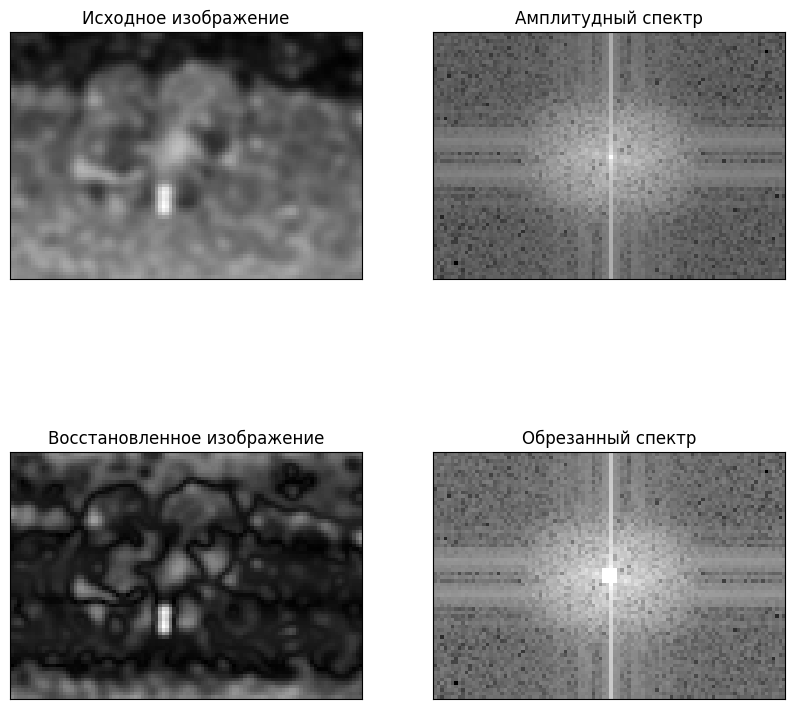

In [17]:
gray_img = cv.cvtColor(cropped_image2, cv.COLOR_BGR2GRAY)
r = 2
rows, cols = gray_img.shape
crow, ccol = np.uint32((rows / 2, cols / 2))
# create a mask first, center square is 1, remaining all zeros
mask = np.ones((rows, cols, 2), np.uint8)
mask[crow - r:crow + r, ccol - r:ccol + r] = 0

# вычисляем фурье-образ
dft = cv.dft(np.float32(gray_img), flags=cv.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

# применяем маску и делаем обратное преобразование Фурье
dft_shift_masked = dft_shift * mask
f_ishift = np.fft.ifftshift(dft_shift_masked)
img_back = cv.idft(f_ishift)
img_back = cv.magnitude(img_back[..., 0], img_back[..., 1])

magnitude_dft_shift = 20 * np.log(
    cv.magnitude(dft_shift[..., 0], dft_shift[..., 1]))
magnitude_dft_shift_masked = 20 * np.log(
    cv.magnitude(dft_shift_masked[..., 0], dft_shift_masked[..., 1]))

# вывод
plt.figure(figsize=(10, 10))
plt.subplot(221), plt.imshow(gray_img, cmap='gray')
plt.title('Исходное изображение'), plt.xticks([]), plt.yticks([])
plt.subplot(222), plt.imshow(magnitude_dft_shift, cmap='gray')
plt.title('Амплитудный спектр'), plt.xticks([]), plt.yticks([])
plt.subplot(223), plt.imshow(img_back, cmap='gray')
plt.title('Восстановленное изображение'), plt.xticks([]), plt.yticks([])
plt.subplot(224), plt.imshow(magnitude_dft_shift_masked, cmap='gray')
plt.title('Обрезанный спектр'), plt.xticks([]), plt.yticks([])
plt.show()


Класс